In [1]:
import copy
import csv
import glob
import importlib
import itertools
import operator
import os
import random
import time
from math import exp, log, pi, sqrt
from os.path import *

import cvxpy as cvx
import keras.layers as layers
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.sparse as sp
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from numba import njit
from scipy.optimize import minimize
from skimage.transform import rescale, resize
from sklearn.decomposition import NMF, PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import cnn_builder as cbuild
import config
import cv2
import dr_methods as drm
import feature_interpretation as cnna
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import niftiutils.visualization as vis
import voi_methods as vm

%matplotlib inline
np.set_printoptions(3)

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
C = config.Config()

## Misc

preds=model.predict(X_test)

pred=[list(P).index(max(P)) for P in preds]

In [5]:
Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']
orig_data_dict, num_samples = cbuild._collect_unaug_data()

features_by_cls, feat_count = cnna.collect_features()
feat_count.pop("homogeneous texture")
#feat_count.pop("central scar")
all_features = sorted(list(feat_count.keys()))
cls_features = {f: [c for c in C.classes_to_include if f in features_by_cls[c]] for f in all_features}

Z_features = cnna.get_annotated_files(features_by_cls)
Z_features.pop("homogeneous texture")
#Z_features.pop("central scar")

num_features = len(all_features)

rcnn = False
num_channels = 128#64*3

voi_df = drm.get_voi_dfs()[0]

In [ ]:
for f in sorted(Z_features):
    print(f, len(Z_features[f]))

M = keras.models.load_model(join(C.model_dir, "model_reader_new1.hdf5"))

In [ ]:
C = config.Config()
T = config.Hyperparams()
T.get_best_hyperparams()
T.padding = ['same', 'same']
T.epochs = 25
T.steps_per_epoch = 300
Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']

ix=0
X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4, Z_test_fixed=Z_reader)
Z_test, Z_train_orig = Z
X_train_orig, Y_train_orig = train_orig
model = cbuild.build_cnn_hyperparams(T)
hist = model.fit_generator(train_generator, steps_per_epoch=T.steps_per_epoch, epochs=T.epochs, validation_data=[X_test, Y_test])
model.save(join(C.model_dir, "model_reader_newpad%d.hdf5" % ix))

In [ ]:
importlib.reload(cbuild)
importlib.reload(config)
C = config.Config()
T = config.Hyperparams()
T.get_best_hyperparams()
T.epochs = 25
T.steps_per_epoch = 300
Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']

for ix in range(40,41):
    X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4, Z_test_fixed=Z_reader)
    Z_test, Z_train_orig = Z
    X_train_orig, Y_train_orig = train_orig
    model = cbuild.build_cnn_hyperparams(T)
    hist = model.fit_generator(train_generator, steps_per_epoch=T.steps_per_epoch, epochs=T.epochs, validation_data=[X_test, Y_test])
    model.save(join(C.model_dir, "model_reader_new%d.hdf5" % ix))

In [7]:
super_cm=[]
X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4, Z_test_fixed=Z_reader)
for model_ix in range(21,41):
    M = keras.models.load_model(join(C.model_dir, "model_reader_new%d.hdf5" % model_ix))
    Y_pred = M.predict(X_test)
    y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
    y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])
    super_cm.append(confusion_matrix(y_true, y_pred))#M.evaluate(X_test, Y_test)[1])

In [87]:
hf.pickle_dump(super_cm, join(C.base_dir, "data", "supercm.bin"))

In [11]:
super_cm = hf.pickle_load(join(C.base_dir, "data", "supercm.bin"))

In [12]:
sumcm = np.stack(super_cm,0).sum(0)

In [13]:
for i in range(C.nb_classes):
    for j in range(C.nb_classes):
        print(sumcm[j,i],end='\t')
    print()

164	0	5	0	1	29	
0	153	7	0	0	4	
2	35	188	0	2	2	
0	0	0	199	1	0	
0	0	0	1	187	0	
34	12	0	0	9	165	


In [12]:
for f in Z_features:
    save_path = "D:\\labeled_features\\"+f.replace('/', '-')
    if not exists(save_path):
        os.makedirs(save_path)
    vm.save_vois_as_imgs(lesion_ids=Z_features[f], save_dir=save_path, separate_by_cls=False)

In [ ]:
vm.reset_accnum("E101483252")

In [ ]:
voi_df[voi_df["acc_num"] == "E103985934"]

# Feature ID

In [51]:
feature_sheet = pd.read_excel(C.xls_name, "Descriptions")

In [64]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()
all_imgs = [orig_data_dict[cls][0] for cls in C.classes_to_include]
all_imgs = np.array(hf.flatten(all_imgs))

all_lesionids = [orig_data_dict[cls][1] for cls in C.classes_to_include]
all_lesionids = np.array(hf.flatten(all_lesionids))

In [57]:
importlib.reload(cnna)
DFs = cnna.feature_id_bulk(range(21,41))
#DFs += cnna.feature_id_bulk(range(11,21))

In [58]:
hf.pickle_dump(DFs, join(C.base_dir, "data", "DFs4.bin"))

In [7]:
DFs = hf.pickle_load(join(C.base_dir, "data", "DFs4.bin"))

In [8]:
filtered_DFs = copy.deepcopy(DFs)

In [9]:
for df in filtered_DFs:
    for ix, row in df.iterrows():
        if row[-7] > row[-5] + 50:# and row[-3] < 0:
            row[-6] = np.nan
            row[-4] = np.nan
            row[-2] = np.nan
        elif row[-5] > row[-3] + 25:# and row[-3] < 0:
            row[-4] = np.nan
            row[-2] = np.nan
        elif row[-3] > row[-1] + 25:# and row[-1] < 0:
            row[-2] = np.nan
        df.loc[ix] = row

In [10]:
importlib.reload(cnna)
feat_df, cls_df, MISCLS, FIRST, MISFIRST, prec_history, recall_history = cnna.process_feat_id_dfs(all_features, filtered_DFs)

In [22]:
for k in sorted(all_features):
    print(k,'-',np.std(prec_history[k]))

arterial phase enhancement - 0.05620322746301306
central scar - 0.21664822839511327
enhancing rim/capsule - 0.07474060805586594
heterogeneous lesion - 0.048344535913172205
hyperenhancing mass on delayed phase - 0.062250531195965055
hypoenhancing core - 0.044931090620768846
infiltrative growth - 0.1133230392883992
isointense on venous/delayed phase - 0.08650671957653717
nodular growth - 0.14020427998584017
nodular or discontinuous enhancement - 0.09967267620633345
progressive centripetal filling - 0.08493900405297754
progressive enhancement - 0.05388530552653148
thin-walled - 0.08544638233285431
washout - 0.10044269089980018


In [28]:
filtered_DFs[9].to_excel("D:\\best_results.xlsx")

In [ ]:
prec_history["total"].index(max(prec_history["total"]))

In [ ]:
np.std(prec_history["total"])

In [36]:
np.save(join(C.base_dir, "data", "miscls"), MISCLS)
np.save(join(C.base_dir, "data", "first"), FIRST)
np.save(join(C.base_dir, "data", "misfirst"), MISFIRST)

In [78]:
print(cls_df["pred_freq"].sum(), cls_df["true_freq"].sum())
(cls_df["num_correct"].sum()/cls_df["pred_freq"].sum(), cls_df["num_correct"].sum()/cls_df["true_freq"].sum())

3339.0 3080.0


(0.7646001796945193, 0.8288961038961039)

In [63]:
feat_df.to_csv(join(C.base_dir, "data", "feat_df.csv"))
cls_df.to_csv(join(C.base_dir, "data", "cls_df.csv"))

answer_features = hf.flatten(answer_key[['feature_1', 'feature_2', 'feature_3', 'feature_4']].values)
unique, counts = np.unique(answer_features, return_counts=True)
base_freq = dict(zip(unique, counts))
base_freq.pop('nan')

features = hf.flatten(df[['feature_1', 'feature_2', 'feature_3', 'feature_4']].values)
unique, counts = np.unique(features, return_counts=True)
freq = dict(zip(unique, counts))
for f in base_freq.keys():
    if f in freq:
        print(f, freq[f])
    else:
        print(f, 0)

# Feature mapping

## Load model

In [3]:
model = keras.models.load_model(join(C.model_dir, "model_no_pad.hdf5"))
front_model = cbuild.pretrain_cnn(model, padding=['same','same'], last_layer=-3, add_activ=True)

In [ ]:
model = keras.models.load_model(join(C.model_dir, "model_resid1.hdf5"))
front_model = cbuild.pretrain_cnn(model, padding=['same','same'], pool_sizes = [(2,2,2),(2,2,2)],
                                              f=[64,64,64,64,64,64,64], skip_con=True, last_layer=-4)

In [ ]:
model = keras.models.load_model(join(C.model_dir, "model_rcnn1.hdf5"))
front_model = cbuild.build_rcnn(trained_model=model, padding=['same','same'], last_layer=-3, kernel_size=(3,3,2),
                                    f=[64,64,64,64,64], pool_sizes=[(2,2,2),(2,2,2)], add_activ=True)

In [46]:
model_ix = 0
model = keras.models.load_model(join(C.model_dir, "model_reader_newpad%d.hdf5" % model_ix)) #models_305
front_model = cbuild.pretrain_cnn(model, padding=['same','same'], last_layer=-3, add_activ=True)

pca = PCA()
all_c3_tr = pca.fit_transform(all_conv3_ch)
pca.singular_values_

In [47]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()

features_by_cls, feat_count = cnna.collect_features()
feat_count.pop("homogeneous texture")
#feat_count.pop("central scar")
all_features = sorted(list(feat_count.keys()))
cls_features = {f: [c for c in C.classes_to_include if f in features_by_cls[c]] for f in all_features}

Z_features = cnna.get_annotated_files(features_by_cls)
Z_features.pop("homogeneous texture")
#Z_features.pop("central scar")

num_features = len(all_features)

rcnn = False
num_channels = 128#64*3

voi_df = drm.get_voi_dfs()[0]

### Calculate average activations for whole population and feature subpops

In [48]:
Z = np.concatenate([orig_data_dict[cls][1] for cls in C.classes_to_include], 0)
aug_factor = 20

#all_conv2_ch = np.empty([0,128])
#all_conv3_ch = np.empty([0,128])
all_conv_ch = np.empty([aug_factor*len(Z),12,12,6,num_channels])

for img_id in range(len(Z)):
    voi_row = voi_df.loc[Z[img_id]]
    for aug_id in range(aug_factor):
        img = np.load(join(C.aug_dir, voi_row['cls'], "%s_%d.npy" % (Z[img_id], aug_id)))
        activ = front_model.predict(np.expand_dims(img, 0))
        all_conv_ch[img_id*aug_factor+aug_id] = activ

In [49]:
all_conv_ch = all_conv_ch.mean(0)
all_conv_sh = cnna.get_shells(all_conv_ch, all_conv_ch.shape[:3])

In [52]:
aug_factor = 75
num_annot = 10
f_conv_ch = {f:np.empty([aug_factor*num_annot,12,12,6,num_channels]) for f in all_features}
f_conv_sh = {f:np.empty([4,num_channels]) for f in all_features}
for f_ix in range(num_features):#relevant_features:
    f = all_features[f_ix]
    Z_f = Z_features[f][:num_annot]
    for img_id in range(len(Z_f)):
        voi_row = voi_df.loc[Z_f[img_id]]
        for aug_id in range(aug_factor):
            img = np.load(join(C.aug_dir, voi_row['cls'], "%s_%d.npy" % (Z_f[img_id], aug_id)))
            activ = front_model.predict(np.expand_dims(img, 0))
            if rcnn:
                activ = np.concatenate(activ[0], -1)
            f_conv_ch[f][img_id*aug_factor+aug_id] = activ

In [53]:
f_conv_sh = {f:np.empty([4,num_channels]) for f in all_features}
for f_ix in range(num_features):
    f = all_features[f_ix]
    f_conv_ch[f] = f_conv_ch[f].mean(0)
    f_conv_sh[f] = cnna.get_shells(f_conv_ch[f], f_conv_ch[f].shape[:3])

In [55]:
print(list(zip(range(len(all_features)), all_features)))

[(0, 'arterial phase enhancement'), (1, 'central scar'), (2, 'enhancing rim/capsule'), (3, 'heterogeneous lesion'), (4, 'hyperenhancing mass on delayed phase'), (5, 'hypoenhancing core'), (6, 'infiltrative growth'), (7, 'isointense on venous/delayed phase'), (8, 'nodular growth'), (9, 'nodular or discontinuous enhancement'), (10, 'progressive centripetal filling'), (11, 'progressive enhancement'), (12, 'thin-walled'), (13, 'washout')]


In [536]:
relevant_features = [11,8,3]
#[5,2,11] #colorectal, [2,0,13] #hcc, [11,8,3] #cholangio, [5,12] #cyst [7,0] #fnh # [4,9,10] #hemangioma
img_dir = "D:\\feature_analysis\\"+cls
if not exists(img_dir):
    os.makedirs(img_dir)

num_rel_f = len(relevant_features)
print(np.array(all_features)[relevant_features])

['progressive enhancement' 'nodular growth' 'heterogeneous lesion']


In [535]:
cls = 'cholangio'
cls_img_set = orig_data_dict[cls][0]

#12783467_0 hcc
#12961059_0 crc
#E102634440_0 icc E102095465_0
#12569826_0 cyst
#E100121654_0 hemangioma
#E101415263_0 fnh E104189184_0

img_id = list(orig_data_dict[cls][1]).index('E102634440_0')
x = cls_img_set[img_id]
h_ic_rot = cnna.get_rotations(x, front_model, rcnn)
test_neurons = h_ic_rot.mean(0)

### new approach

dims = (12,12,6)
I = 12*12
A = num_rel_f
J = num_channels
K = I*J
K3 = K*3
alpha = 1
beta = 1

In [ ]:
# h_ka = np.empty(K,A)
# h_ka = ln(max(n_ka – n_avg_k, 0) + 1)
# g_ka = np.empty((K,A))
# n = 
# m = 
# G_k = np.eye(K)

# g_ka = argmin( norm(h_k*(g_ka.sum(-1) - n - m)) + norm(matmul(G_ka), g_ka) )
# g_ka = matmul( matmul( np.inv(diag(h_k**2) + matmul(G_ka.T, G_ka)) , diag(h_k).T ) , matmul(diag(h_k), (n - m)) )

In [55]:
G = np.diag([alpha]*I, 0)
for i in range(I-1,0,-1):
    G += np.diag([-beta]*i, i-I)

In [56]:
G = sp.block_diag(tuple([G]*J*3))

In [57]:
G.shape

(55296, 55296)

In [143]:
importlib.reload(cnna)

<module 'cnn_analyzer' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_analyzer.py'>

In [63]:
slice_num = test_neurons.shape[2]//2

In [64]:
n_k = test_neurons[:,:,slice_num].flatten()
m_k = cnna.average_shells(all_conv_ch, dims)[:,:,slice_num].flatten()
# this ordering splits feature elements, i.e. [F1 F2 F3]
# within each feature, channels are grouped so spatial indices are split, i.e. F1 = [S(0,0,0) S2(1,0,0) ... S(11,11,5)]

In [67]:
nu_ja = np.stack([f_conv_ch[f].mean((0,1))[slice_num] for f in np.array(all_features)[relevant_features]], -1)
nu_javg = all_conv_ch.mean((0,1))[slice_num]

In [161]:
h_ja = np.empty((J, num_rel_f))
for f_ix in range(num_rel_f):
    dnu = nu_ja[:,f_ix] - nu_javg
    dnu[dnu < 0] = 0
    h_ja[:,f_ix] = np.log(dnu + 1)
h_ja = np.tile(h_ja, (I,1,1))

In [166]:
h_ja.shape

(144, 128, 3)

In [172]:
np.diag(h_ja[:,:,0].flatten()).shape

(18432, 18432)

In [ ]:
h_k = sp.bmat([sp.diags(h_ja[:,:,0].flatten()), sp.diags(h_ja[:,:,1].flatten()), sp.diags(h_ja[:,:,2].flatten())])

In [ ]:
h_k.shape

In [102]:
b = n_k - m_k

In [131]:
G.shape

(55296, 55296)

In [ ]:
x = cvx.Variable(3*K,1)
objective = cvx.Minimize(cvx.sum_squares(h_k*x - b) + cvx.norm(x,1) + cvx.sum_squares(G*x))
constraints = [-1 <= x, x <= 100]
prob = cvx.Problem(objective, constraints)

# The optimal objective is returned by prob.solve().
result = prob.solve()
# The optimal value for x is stored in x.value.
X = x.value

In [106]:
X.shape

(55296, 1)

In [ ]:
gauss = cnna.get_gaussian_mask()

In [108]:
X.max()

0.2760379650044357

In [127]:
g = np.reshape(np.array(X), (3,12,12,num_channels))
#g = np.transpose(g, (3,0,1,2))
g = g.sum(-1)
g = np.stack([g]*3, -1)

In [ ]:
g.max()

plt.imshow(g[0])

plt.imshow(g[1])

plt.imshow(g[2])

## old approach

In [545]:
importlib.reload(cnna)
W = cnna.calculate_W(f_conv_ch, all_features, relevant_features, num_rel_f, num_channels)

['progressive enhancement' 'nodular growth' 'heterogeneous lesion']


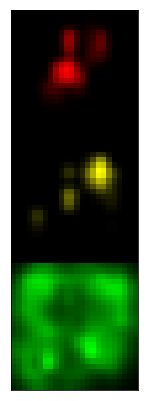

In [546]:
gauss = cnna.get_gaussian_mask(3)
z = orig_data_dict[cls][1][img_id]

fixed_width = 100
bw = False
width = x.shape[0]
overlaid_img_clr = np.zeros((width*3, x.shape[1], 3))
overlaid_img = x - np.amin(x)

high_window = [1,1,1] #relative intensity
low_window = [0.4,0.2,0.] #relative intensity

sal_map = cnna.get_saliency_map(W, test_neurons, num_rel_f)
RGB = []
if bw:
    for f_num in range(3):
        sal_map_f = overlaid_img[:,:,:,f_num]
        hi_thresh = sal_map_f.max()*1
        lo_thresh = sal_map_f.max()*0.2
        sal_map_f[sal_map_f > hi_thresh] = hi_thresh
        sal_map_f[sal_map_f < lo_thresh] = lo_thresh
        sal_map_f -= sal_map_f.min()
        RGB.append(sal_map_f[:,:,sal_map_f.shape[2]//2])
else:
    for f_num in range(num_rel_f):
        sal_map[f_num] *= gauss
        sal_map[f_num] -= sal_map[f_num].min()
        hi_thresh = sal_map[f_num].max()*high_window[f_num]
        lo_thresh = sal_map[f_num].max()*low_window[f_num]
        sal_map[f_num][sal_map[f_num] > hi_thresh] = hi_thresh
        sal_map[f_num][sal_map[f_num] < lo_thresh] = lo_thresh
        sal_map[f_num] -= sal_map[f_num].min()
        sal_map_f = tr.scale3d(sal_map[f_num], (2,2,2))
        RGB.append(sal_map_f[:,:,sal_map_f.shape[2]//2])
    
overlaid_img_clr[:width,:,0] = RGB[0]
overlaid_img_clr[width:width*2,:,0] = overlaid_img_clr[width:width*2,:,1] = RGB[1]
if bw or num_rel_f >= 3:
    overlaid_img_clr[width*2:,:,1] = RGB[2]
    
overlaid_img_clr -= overlaid_img_clr.min() - 0
overlaid_img_clr *= 1 / overlaid_img_clr.max()

if bw:
    overlaid_img_clr = overlaid_img_clr.mean(-1)
    overlaid_img_clr = np.transpose(np.tile(overlaid_img_clr, (3,1,1)), (1,2,0))

overlaid_img_clr[:width] *= 1 / overlaid_img_clr[:width].max()
overlaid_img_clr[width:width*2] *= 1 / overlaid_img_clr[width:width*2].max()
if bw or num_rel_f >= 3:
    overlaid_img_clr[width*2:] *= 1 / overlaid_img_clr[width*2:].max()

fig = plt.imshow(overlaid_img_clr)
fig.get_figure().set_figheight(7)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
print(np.array(all_features)[relevant_features])

In [505]:
lesion_imgs = [np.stack([RGB[i]]*3, axis=-1) for i in range(3)]
for i in range(3):
    lesion_imgs[i] -= lesion_imgs[i].min()
    lesion_imgs[i] = ((lesion_imgs[i]/lesion_imgs[i].max())* 255).astype('uint8')

In [523]:
segs = [RGB[i] > np.percentile(RGB[i], 80) for i in range(3)]
#segs = [RGB[i] > np.amax(RGB[i])*.5 for i in range(3)]
contour = [masks.get_contour(segs[i]) for i in range(3)]

In [ ]:
b = cv2.drawContours(copy.deepcopy(lesion_imgs[1]), contour[2], -1, (255,0,0), 1)
#b[b < 100] = 100
#b[b > 200] = 200
b -= b.min()
b = b/b.max()
fig = plt.imshow(b)
fig.get_figure().set_figheight(7)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [ ]:
plt.imsave(join(dirname(img_dir), "samples", z+"_eq_washout.png"), resize(b, [fixed_width, fixed_width]))

a = np.ones([20,20,3], dtype='uint8')
a[3:16,3:10,:] = 245
_,thresh = cv2.threshold(a[:,:,0],127,255,0)
_,contours,_ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
b = cv2.drawContours(a, contours, 0, (0,255,0), 1)
plt.imshow(b/255)

In [534]:
plt.imsave(join(img_dir, z+"_new.png"), resize(overlaid_img_clr, [fixed_width*3, fixed_width]))#(fig*255/fig.max()).astype(int))

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [494]:
plt.imsave(join(img_dir, z+"_bw.png"), resize(overlaid_img_clr, [fixed_width*3, fixed_width]))#(fig*255/fig.max()).astype(int))

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## Feature scoring

In [120]:
importlib.reload(cbuild)
back_model = cbuild.build_cnn(trained_model=model, padding=['same','same'], pool_sizes = [(2,2,2),(2,2,2)],
                                          f=[64,64,64,64,64,64,64], skip_con=True)

In [129]:
importlib.reload(cbuild)
back_model = cbuild.build_cnn(trained_model=model, padding=['same','same'])

In [62]:
back_model = cbuild.build_rcnn(trained_model=model, padding=['same','same'], kernel_size=(3,3,2),
                                    f=[64,64,64,64,64], pool_sizes = [(2,2,2),(2,2,2)], first_layer=-2)

In [540]:
z_bias = back_model.layers[-1].get_weights()[1]

In [423]:
C.classes_to_include

['hcc', 'cholangio', 'colorectal', 'cyst', 'hemangioma', 'fnh']

In [539]:
def get_cls_sep(z, cls_num=1):
    if cls != C.classes_to_include[cls_num]:
        print("Check cls_num")
        return
    ixs = list(set(range(len(C.classes_to_include))).difference([cls_num]))
    return z[cls_num] - max(z[ixs])

In [444]:
def split_rcnn(c):
    if not rcnn:
        return c
    return np.array([c[:,:,:,:192//3], c[:,:,:,192//3:192*2//3], c[:,:,:,192*2//3:]])

In [541]:
test_n = split_rcnn(test_neurons)

In [547]:
sal_map = cnna.get_saliency_map(W, test_neurons, num_rel_f)

z_actual = back_model.predict(np.expand_dims(test_n,0))[0] - z_bias

h_ja = np.zeros((num_rel_f, test_neurons.shape[-1]))
for f_num in range(num_rel_f):
    h_ja[f_num] = f_conv_ch[all_features[relevant_features[f_num]]].mean((0,1,2))

test_n_ch = test_neurons.mean((0,1,2))

if num_rel_f == 3:
    fxn = lambda w: sum((w[0]*h_ja[0] + w[1]*h_ja[1] + w[2]*h_ja[2] - test_n_ch)**2) - \
               .1*(log(w[0]) + log(w[1]) + log(w[2]))
elif num_rel_f == 2:
    fxn = lambda w: sum((w[0]*h_ja[0] + w[1]*h_ja[1] - test_n_ch)**2) - \
               .1*(log(w[0]) + log(w[1]))
sol = minimize(fxn, [1,1,1], bounds = ((0.0001, None), (0.0001, None), (0.0001, None)))
w_a = sol['x']
w_a

array([0.69209229, 0.30963196, 0.05749841])

In [505]:
def get_diff(a,b):
    return a-b

In [370]:
contrib_sample = np.zeros(test_neurons.shape)
for ch_ix in range(test_neurons.shape[-1]):
    contrib_sample[:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[0]*h_ja[0, ch_ix] - w_a[1]*h_ja[1, ch_ix]

z_base = back_model.predict(np.expand_dims(split_rcnn(contrib_sample),0))[0] - z_bias

In [371]:
dz_actual = get_cls_sep(z_actual)
dz_base = get_cls_sep(z_base)
den = dz_actual - dz_base

In [372]:
contrib_sample = np.zeros((num_rel_f, *test_neurons.shape))
for f_num in range(num_rel_f):
    for ch_ix in range(test_neurons.shape[-1]):
        contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[f_num]*h_ja[f_num, ch_ix]# * (sal_map[f_num] > np.median(sal_map[f_num]))

z_onef = np.empty((num_rel_f, 6))
for f_num in range(num_rel_f):
    z_onef[f_num] = back_model.predict(np.expand_dims(split_rcnn(contrib_sample[f_num]),0))[0] - z_bias

In [373]:
dz_0 = get_cls_sep(z_onef[0])
dz_1 = get_cls_sep(z_onef[1])

In [374]:
num_0 = []
num_0.append(get_diff(dz_0,dz_base))
num_0.append(get_diff(dz_actual,dz_1))

num_1 = []
num_1.append(get_diff(dz_1,dz_base))
num_1.append(get_diff(dz_actual,dz_0))

In [375]:
np.mean(num_0) / den, np.mean(num_1) / den

(0.9599141953135638, 0.0400857632214758)

In [548]:
contrib_sample = np.zeros(test_neurons.shape)
for ch_ix in range(test_neurons.shape[-1]):
    contrib_sample[:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[0]*h_ja[0, ch_ix] - w_a[1]*h_ja[1, ch_ix] - w_a[2]*h_ja[2, ch_ix]

z_base = back_model.predict(np.expand_dims(split_rcnn(contrib_sample),0))[0] - z_bias

z_onef = np.zeros((num_rel_f, 6))
for ch_ix in range(test_neurons.shape[-1]):
    contrib_sample[:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[0]*h_ja[0, ch_ix] - w_a[1]*h_ja[1, ch_ix]
z_onef[2] = back_model.predict(np.expand_dims(split_rcnn(contrib_sample),0))[0] - z_bias
for ch_ix in range(test_neurons.shape[-1]):
    contrib_sample[:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[0]*h_ja[0, ch_ix] - w_a[2]*h_ja[2, ch_ix]
z_onef[1] = back_model.predict(np.expand_dims(split_rcnn(contrib_sample),0))[0] - z_bias
for ch_ix in range(test_neurons.shape[-1]):
    contrib_sample[:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[1]*h_ja[1, ch_ix] - w_a[2]*h_ja[2, ch_ix]
z_onef[0] = back_model.predict(np.expand_dims(split_rcnn(contrib_sample),0))[0] - z_bias

contrib_sample = np.zeros((num_rel_f, *test_neurons.shape))
for f_num in range(num_rel_f):
    for ch_ix in range(test_neurons.shape[-1]):
        contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[f_num]*h_ja[f_num, ch_ix]# * (sal_map[f_num] > np.median(sal_map[f_num]))

    
z_twof = np.empty((num_rel_f, 6))
for f_num in range(num_rel_f):
    z_twof[f_num] = back_model.predict(np.expand_dims(split_rcnn(contrib_sample[f_num]),0))[0] - z_bias

dz_actual = get_cls_sep(z_actual)
dz_base = get_cls_sep(z_base)
den = dz_actual - dz_base

C.classes_to_include

dz_0 = get_cls_sep(z_onef[0])
dz_1 = get_cls_sep(z_onef[1])
dz_2 = get_cls_sep(z_onef[2])
dz_01 = get_cls_sep(z_twof[2])
dz_02 = get_cls_sep(z_twof[1])
dz_12 = get_cls_sep(z_twof[0])

num_0 = []
num_0.append(get_diff(dz_0,dz_base))
num_0.append(get_diff(dz_actual,dz_12))
num_0.append(get_diff(dz_01,dz_1))
num_0.append(get_diff(dz_02,dz_2))

num_1 = []
num_1.append(get_diff(dz_1,dz_base))
num_1.append(get_diff(dz_actual,dz_02))
num_1.append(get_diff(dz_01,dz_0))
num_1.append(get_diff(dz_12,dz_2))

num_2 = []
num_2.append(get_diff(dz_2,dz_base))
num_2.append(get_diff(dz_actual,dz_01))
num_2.append(get_diff(dz_02,dz_0))
num_2.append(get_diff(dz_12,dz_1))

rat0 = np.mean([num_0[i] / (num_0[i]+num_1[i]+num_2[i]) for i in range(4)])
rat1 = np.mean([num_1[i] / (num_0[i]+num_1[i]+num_2[i]) for i in range(4)])
rat2 = np.mean([num_2[i] / (num_0[i]+num_1[i]+num_2[i]) for i in range(4)])

In [549]:
den = sum([np.mean(num_0), np.mean(num_1), np.mean(num_2)])

In [433]:
[get_diff(dz_actual,dz_12), get_diff(dz_actual,dz_02), get_diff(dz_actual,dz_01)] / np.sum([get_diff(dz_actual,dz_12), get_diff(dz_actual,dz_02), get_diff(dz_actual,dz_01)])

array([0.39474632, 0.5974937 , 0.00775998])

In [550]:
np.mean(num_0) / den, np.mean(num_1) / den, np.mean(num_2) / den

(0.6382034940505372, 0.29672371006297193, 0.06507279588649086)

H_JA0 = np.tile(w_a[0]*h_ja[0], (*test_neurons.shape[:3], 1))
H_JA1 = np.tile(w_a[1]*h_ja[1], (*test_neurons.shape[:3], 1))
H_JA2 = np.tile(w_a[2]*h_ja[2], (*test_neurons.shape[:3], 1))

P = 0
Q = 0
KL = 0
for df0 in np.linspace(0,1,10):
    for df1 in np.linspace(0,1,10):
        #pos = test_neurons - df0*H_JA0 - df1*H_JA1
        #z_temp = back_model.predict(np.expand_dims(pos,0))[0] - z_bias
        #if get_cls_sep(z_temp) > 0:
        #    P += 1
            
        for df2 in np.linspace(0,1,10):
            neg = test_neurons - df2*H_JA0 - df1*H_JA1 - df0*H_JA2
            z_temp = back_model.predict(np.expand_dims(neg,0))[0] - z_bias
            if df2==0:
                P = get_cls_sep(z_temp)
                Z = copy.deepcopy(z_temp)
            Q += get_cls_sep(z_temp) / 10
        KL += (exp(P) - exp(sum(Z)))*(P-Q)
KL

In [246]:
layer_dict = dict([(layer.name, layer) for layer in model_conv3_pre.layers[1:]])
layer_dict

{'activation_22': <keras.layers.core.Activation at 0x19019d296a0>,
 'activation_23': <keras.layers.core.Activation at 0x19019da3b70>,
 'activation_24': <keras.layers.core.Activation at 0x19019e215c0>,
 'batch_normalization_28': <keras.layers.normalization.BatchNormalization at 0x19019d315c0>,
 'batch_normalization_29': <keras.layers.normalization.BatchNormalization at 0x19019d53cf8>,
 'batch_normalization_30': <keras.layers.normalization.BatchNormalization at 0x19019deff98>,
 'concatenate_10': <keras.layers.merge.Concatenate at 0x19019cc9c88>,
 'conv3d_43': <keras.layers.convolutional.Conv3D at 0x190d524a898>,
 'conv3d_44': <keras.layers.convolutional.Conv3D at 0x190a69bd4a8>,
 'conv3d_45': <keras.layers.convolutional.Conv3D at 0x19019ce1ba8>,
 'conv3d_46': <keras.layers.convolutional.Conv3D at 0x19019d0f080>,
 'conv3d_47': <keras.layers.convolutional.Conv3D at 0x19019d5ee48>,
 'dropout_18': <keras.layers.core.Dropout at 0x19019d29780>,
 'dropout_19': <keras.layers.core.Dropout at 0x19

In [272]:
importlib.reload(cnna)

<module 'cnn_analyzer' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_analyzer.py'>

In [168]:
test_neurons = rcnn_conv3.predict(np.expand_dims(x,0))[0]
test_n = np.concatenate(test_neurons, -1)

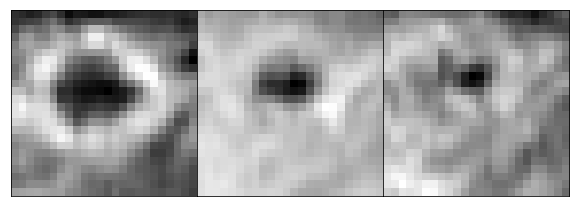

In [95]:
hf.draw_slices(x)

In [175]:
sal_map = cnna.get_saliency_map(W, test_n, num_rel_f)

h_ja = np.zeros((num_rel_f, test_neurons.shape[-1]*3))
for f_num in range(num_rel_f):
    h_ja[f_num] = f_rcnn3_ch[all_features[relevant_features[f_num]]].mean((0,1,2))

contrib_sample[f_num,:,:,:,ch_ix] = test_n_ch = test_n

sol = minimize(lambda w: sum((w[0]*h_ja[0] + w[1]*h_ja[1] + w[2]*h_ja[2] - test_n_ch)**2) - .001*(log(w[0]) + log(w[1]) + log(w[2])), [15,1,1],
         bounds = ((0.001, None), (0.001, None), (0.001, None)))
w_a = sol['x']

ValueError: could not broadcast input array from shape (12,12,6,192) into shape (12,12,6)

In [228]:
h_ja_full = copy.deepcopy(h_ja)

In [1358]:
h_ja = copy.deepcopy(h_ja_full)

In [229]:
for f_num in range(num_rel_f):
    h_ja[f_num] = w_a[f_num]*h_ja[f_num]
    #h_ja[f_num][h_ja[f_num] < np.median(h_ja[f_num])] = 0
    h_ja[f_num] /= h_ja[f_num][h_ja[f_num] > 0].mean()
for ch_ix in range(test_neurons.shape[-1]):
    h_ja[:, ch_ix][h_ja[:, ch_ix] != np.max(h_ja[:, ch_ix])] = 0

In [1387]:
w_a = w_a/w_a.mean()

In [248]:
gauss = cnna.get_gaussian_mask(2)
sal_map = cnna.get_saliency_map(W, test_neurons, num_rel_f)
for f_num in range(num_rel_f):
    sal_map[f_num] *= gauss
    #sal_map[f_num][sal_map[f_num] < np.median(sal_map[f_num])] = 0
    sal_map[f_num] -= sal_map[f_num].min()
    sal_map[f_num] /= sal_map[f_num].mean()
    for ch_ix in range(test_neurons.shape[-1]):
        contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - h_ja[f_num,ch_ix]*sal_map[f_num] \
                + 0#h_ja[f_num-1,ch_ix]*sal_map[f_num-1]/2 + h_ja[f_num-2,ch_ix]*sal_map[f_num-2]/2
contrib_sample[contrib_sample < 0] = 0

In [262]:
importlib.reload(cnna)

<module 'cnn_analyzer' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_analyzer.py'>

In [244]:
rcnn_conv3.input.shape

TensorShape([Dimension(None), Dimension(24), Dimension(24), Dimension(12), Dimension(3)])

In [205]:
gauss.shape

(12, 12, 6)

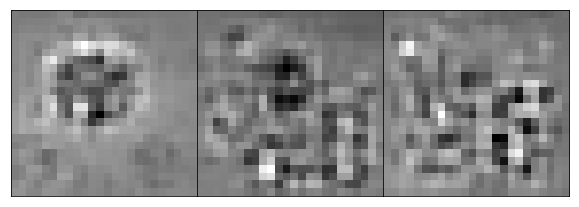

In [263]:
for f_num in range(num_rel_f):
    #print(all_features[relevant_features[f_num]])
    x_est = cnna.visualize_activations(rcnn_conv3, join(img_dir, "2f"+all_features[relevant_features[f_num]]+".png"),
                         split_rcnn(contrib_sample[f_num]), init_img=x, rotate=True, stepsize=.1, num_steps=2)

h_ja = copy.deepcopy(h_ja_full)
for f_num in range(num_rel_f):
    #h_ja[f_num] = w_a[f_num]*h_ja[f_num]
    #h_ja[f_num][h_ja[f_num] < np.median(h_ja[f_num])] = 0
    h_ja[f_num] /= h_ja[f_num][h_ja[f_num] > 0].mean()
for ch_ix in range(test_neurons.shape[-1]):
    h_ja[:, ch_ix][h_ja[:, ch_ix] != np.max(h_ja[:, ch_ix])] = 0
    
f_num = 0
sal_map = get_saliency_map(W, test_neurons, num_rel_f)
sal_map[f_num] *= gauss
sal_map[f_num][sal_map[f_num] < np.median(sal_map[f_num])] = 0
sal_map[f_num] -= sal_map[f_num].min()
sal_map[f_num] /= sal_map[f_num].mean()
for ch_ix in range(test_neurons.shape[-1]):
    contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - h_ja[f_num,ch_ix]*sal_map[f_num] \
            + h_ja[f_num-1,ch_ix]*sal_map[f_num-1]/10 + h_ja[f_num-2,ch_ix]*sal_map[f_num-2]/10
contrib_sample[contrib_sample < 0] = 0
print(all_features[relevant_features[f_num]])
x_est = cnna.visualize_activations(model_conv3_pre, join(img_dir, "2f"+all_features[relevant_features[f_num]]+".png"),
                     contrib_sample[f_num], init_img=x, rotate=False, stepsize=.1, num_steps=1)

In [ ]:
for r in range(4):
    x_est = cnna.visualize_activations(model_conv3_pre, join(img_dir, "2f"+all_features[relevant_features[f_num]]+".png"),
                         contrib_sample[f_num], init_img=x, rotate=False, stepsize=.5, num_steps=1)

In [1287]:
h_ic = [model_conv3_pre.predict(np.expand_dims(np.rot90(x,r),0))[0] for r in range(4)]
h_ic += [model_conv3_pre.predict(np.expand_dims(np.flipud(np.rot90(x,r)),0))[0] for r in range(4)]
h_ic += [model_conv3_pre.predict(np.expand_dims(np.fliplr(np.rot90(x,r)),0))[0] for r in range(4)]

for r in range(len(h_ic)):
    h_ic[r][h_ic[r] < 0] = 0

h_ic_rot = [np.rot90(h_ic[r], 4-r) for r in range(4)] #rotated back into original frame
h_ic_rot += [np.rot90(np.flipud(h_ic[r]), 4-r) for r in range(4,8)]
h_ic_rot += [np.rot90(np.fliplr(h_ic[r]), 4-r) for r in range(8,12)]

h_ic_rot = np.array(h_ic_rot)

progressive uniform enhancement (crc)


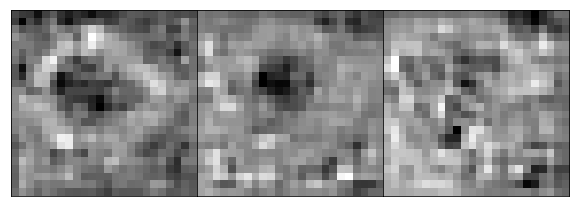

In [1295]:
x_est=[]
for r in range(12):
    test_neurons = h_ic_rot[r]
    sal_map = cnna.get_saliency_map(W, test_neurons, num_rel_f)

    z_actual = model_conv3_input.predict(np.expand_dims(test_neurons,0))[0] - z_bias

    h_ja = np.zeros((num_rel_f, test_neurons.shape[-1]))
    for f_num in range(num_rel_f):
        h_ja[f_num] = conv3_ch_plus[all_features[relevant_features[f_num]]].mean((0,1,2))

    test_n_ch = test_neurons.mean((0,1,2))

    sol = minimize(lambda w: sum((w[0]*h_ja[0] + w[1]*h_ja[1] + w[2]*h_ja[2] - test_n_ch)**2) - .001*(log(w[0]) + log(w[1]) + log(w[2])), [15,1,1],
             bounds = ((0.001, None), (0.001, None), (0.001, None)))
    w_a = sol['x']

    for f_num in range(num_rel_f):
        #h_ja[f_num] = w_a[f_num]*h_ja[f_num]
        #h_ja[f_num][h_ja[f_num] < np.median(h_ja[f_num])] = 0
        h_ja[f_num] /= h_ja[f_num][h_ja[f_num] > 0].mean()
    for ch_ix in range(test_neurons.shape[-1]):
        h_ja[:, ch_ix][h_ja[:, ch_ix] != np.max(h_ja[:, ch_ix])] = 0

    contrib_sample = np.zeros((num_rel_f, *test_neurons.shape))
    
    #for f_num in range(num_rel_f):
    f_num = 0
    for ch_ix in range(test_neurons.shape[-1]):
        contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[f_num]*h_ja[f_num, ch_ix]

    sal_map = cnna.get_saliency_map(W, test_neurons, num_rel_f)
    sal_map[f_num] *= gauss
    sal_map[f_num][sal_map[f_num] < np.median(sal_map[f_num])] = 0
    sal_map[f_num] -= sal_map[f_num].min()
    sal_map[f_num] /= sal_map[f_num].mean()
    for ch_ix in range(test_neurons.shape[-1]):
        contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - h_ja[f_num,ch_ix]*sal_map[f_num] \
                + h_ja[f_num-1,ch_ix]*sal_map[f_num-1] + h_ja[f_num-2,ch_ix]*sal_map[f_num-2]
    contrib_sample[contrib_sample < 0] = 0
    x_est.append(cnna.visualize_activations(model_conv3_pre, join(img_dir, "2f"+all_features[relevant_features[f_num]]+".png"),
                         contrib_sample[f_num], init_img=x, rotate=False, stepsize=.1, num_steps=1))
print(all_features[relevant_features[f_num]])

In [1302]:
x_est_avg = np.min(np.array(x_est),0)

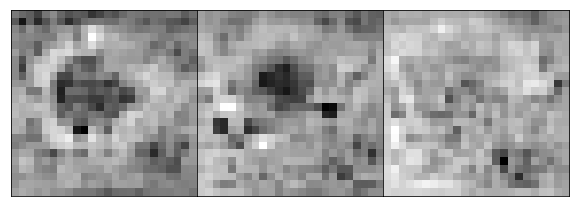

In [1303]:
hf.draw_slices(x_est_avg)

In [989]:
importlib.reload(cnna)

<module 'cnn_analyzer' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_analyzer.py'>

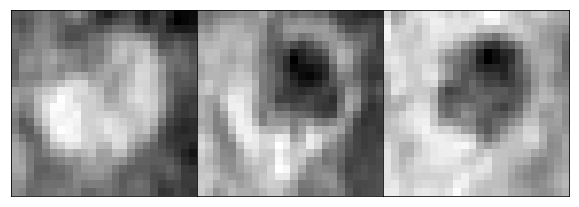

In [1395]:
f_num = 0
x_est = cnna.visualize_activations(model_conv3_pre, join(img_dir, "test.png"),
                     test_neurons, init_img=x, rotate=False, stepsize=.01, num_steps=100)

In [ ]:
contrib_sample = np.zeros((num_rel_f, *test_neurons.shape))
for f_num in range(num_rel_f):
    for ch_ix in range(test_neurons.shape[-1]):
        contrib_sample[f_num,:,:,:,ch_ix] = test_neurons[:,:,:,ch_ix] - w_a[f_num]*h_ja[f_num, ch_ix]

In [5]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()
filters_by_cls = {cls: model_dense_outputs.predict(orig_data_dict[cls][0], verbose=False) for cls in C.classes_to_include}
fig = cnna.tsne(filters_by_cls)
fig.show()

In [224]:
len(hf.flatten([list(feature_sheet["evidence1"+cls].dropna().values) for cls in C.classes_to_include]))

137

model_conv1 = cbuild.pretrain_model(model, last_layer=-6, add_activ=True)
model_conv2 = cbuild.pretrain_model(model, last_layer=-5, add_activ=True)
model_conv3 = cbuild.pretrain_model(model, last_layer=-4, add_activ=True)
model_dense = cbuild.pretrain_model(model, last_layer=-3, add_activ=True)

cls = 'cyst'
cls_img_set = orig_data_dict[cls][0]
cls_activ_set = model_conv3.predict(cls_img_set)

nmf = NMF(4)
cls_activ_set_xform = nmf.fit_transform(cls_activ_set.mean((1,2,3)))

nmf_comps = [nmf.components_[i] * (nmf.components_[i] > np.median(nmf.components_,0)*2) for i in range(4)]

In [187]:
importlib.reload(cnna)

<module 'cnn_analyzer' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_analyzer.py'>

In [ ]:
cnna.visualize_layer_weighted(model_frozen, 'conv3d_11', "D:\\filters", K.constant(nmf_comps[0]))

In [277]:
activs0 = cls_activ_set[:,:,:,:,nmf_comps[1] > 0]
activ_map0 = activs0.mean(4)

In [278]:
activ_map0, _ = tr.rescale_img(np.transpose(activ_map0, (1,2,3,0)), cls_img_set[img_id].shape[:3])
activ_map0 = np.transpose(activ_map0, (3,0,1,2))

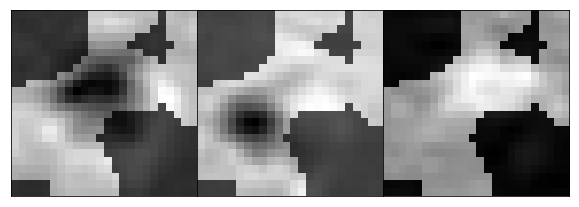

In [282]:
img_id = 1
alpha = 1.
overlaid_img = cls_img_set[img_id] - np.amin(cls_img_set[img_id])
overlaid_img = np.stack([((activ_map0[img_id] > np.mean(activ_map0[img_id])*alpha)+.5) * overlaid_img[:,:,:,i] for i in range(3)], 3)
hf.draw_slices(overlaid_img)

In [ ]:
hf.draw_slices(cls_img_set[img_id])

In [596]:
dw = np.linspace(0,5,100)
dy = np.empty((num_rel_f, len(dw)))
w_f = np.empty(num_rel_f)

for f_num in range(num_rel_f):
    for w_ix in range(len(dw)):
        z_f = model_conv3_input.predict(np.expand_dims(test_neurons - dw[w_ix]*contrib_sample[f_num],0))[0]
        dy[f_num,w_ix] = z_f[1] - np.amax(z_f[[0,2,3,4,5]])
    #w_f[f_num] = (dy[f_num] < 0).nonzero()[0][0]

In [464]:
z_f[:1]+z_f[2:]

array([  0.12477922, -13.959014  , -11.985743  , -11.229456  ],
      dtype=float32)

In [ ]:
f_num = 2
[dy[f_num][i] - dy[f_num][i-1] for i in range(1,len(dy[f_num]))]

In [ ]:
dy[0]

26

In [361]:
sal_map = cnna.get_saliency_map(W, test_neurons, num_rel_f)
z_f = np.empty((num_rel_f, 6))
for f_num in range(num_rel_f):
    contrib_sample = np.transpose(np.tile(sal_map[f_num], (128,1,1,1)), (1,2,3,0)) + test_neurons
    #print(all_features[relevant_features[f_num]])
    z_f[f_num] = model_conv3_input.predict(np.expand_dims(contrib_sample,0)) - z_actual

In [388]:
noise = np.random.normal(size=(1000,*test_neurons.shape))

In [389]:
z_base = model_conv3_input.predict(noise)

In [366]:
z_base = model_conv3_input.predict(np.expand_dims(np.ones(test_neurons.shape),0))

In [397]:
z_base = z_base.mean(0)

In [398]:
Z = np.concatenate((z_f, np.expand_dims(z_base,0)))

In [400]:
W = Z.shape

(4, 6)

In [362]:
z_f

array([[-3.15560436,  0.9448576 , -1.96781707, -0.67129517, -2.05151415,
         2.70983791],
       [-1.69611597, -0.05921125, -1.89745355,  0.80170631, -2.63591051,
         1.83641386],
       [-1.55328608,  0.75187254, -1.75524974, -0.0799427 , -1.24825335,
         1.33727264]])

In [ ]:
model_conv3_input.predict(np.expand_dims(test_neurons,0))

In [318]:
C.classes_to_include

['hcc', 'cholangio', 'colorectal', 'cyst', 'hemangioma', 'fnh']